# Homework 2 - Data Science with CO2

__Hand-in__:

- __Due: 07.04.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Description of the project:

   In this assignment, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect outliers and drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 

1. The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2. A clustering of the city of Zurich in 17 different city zones and the **zone** in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements. 

## Prior knowledge:
    
The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains) and exposed to stronger winds, are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements on temperature and humidity.


### To start with: 

The following csv files will be needed which can be found in the `../data/` folder: 

1. `CO2_sensor_measurements.csv`
    
   __Description__: It containts the CO2 measurements (CO2), the name of the site (LocationName), a unique sensor identifier (SensorUnit_ID), and the time instance in which the measurement was taken (timestamp).
    
2. `temperature_humidity.csv`

   __Description__: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp (Timestamp). For each SensorUnit_ID, the temperature and the humidity can be found in the corresponding columns of the dataframe (SensorUnit_ID.temperature, SensorUnit_ID.humidity).
    
3. `sensor_metadata_updated.csv`

   __Description__: It contains the name of the site (LocationName), the zone index (zone), the altitude in meters, and longitude, latitude. 

Import the following python packages:

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import array
import os
import matplotlib.dates as dates
%matplotlib inline

### PART I: Handling time series with pandas (10 points)

a) **8/10** Merge the `CO2_sensor_measurements.csv`, `temperature_humidity.csv`, and `sensors_metadata.csv`, into a single dataframe like this:

| timestamp | LocationName | SensorUnit_ID | CO2 | temperature | humidity | zone | altitude | lon | lat |
|:---------:|:------------:|:-------------:|:---:|:-----------:|:--------:|:----:|:--------:|:---:|:---:|
|    ...    |      ...     |      ...      | ... |     ...     |    ...   |  ... |    ...   | ... | ... |

The merged dataframe contains as index the time instance (timestamp) of the measurements, and columns the location of the site (LocationName), the sensor ID (SensorUnit_ID), the CO2 measurement, the temperature, the humidity, the zone, the altitude, the longitude and the latitude. For each measurement, take the average over an interval of 30 min. If there are missing measurements, interpolate them linearly from measurements that are close by in time.

__Hints__: The following methods could be useful

1. ```python 
pandas.DataFrame.resample()
``` 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
    
2. ```python
pandas.DataFrame.interpolate()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    
3. ```python
pandas.DataFrame.mean()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html
    
4. ```python
pandas.DataFrame.append()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

**Import the data**

In [119]:
CO2 = pd.read_csv('../data/CO2_sensor_measurements.csv', sep='\t')
temp_hum = pd.read_csv('../data/temperature_humidity.csv', sep='\t')
metadata = pd.read_csv('../data/sensors_metadata_updated.csv', sep=',').iloc[:, 1:]

In [3]:
CO2.head(1)

,timestamp,LocationName,SensorUnit_ID,CO2
0,2017-10-01 00:05:00,ZGHD,1014,593.321562


In [4]:
temp_hum.head(1)

,Timestamp,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
0,2017-10-01 00:00:00,11.39,92.262787,10.55,91.949982,11.02,92.613739,11.05,89.811844,11.38,...,10.13,96.828979,10.5,95.858139,10.7,94.524902,11.35,90.288681,11.44,90.118927


In [5]:
metadata.head(1)

,LocationName,zone,altitude,LAT,LON,X,Y
0,AJGR,2,627.8,47.33321,8.4803,243005.0,678731.4


*Checking for missing values to see what needs to be interpolated.*

In [120]:
print('Missing values in CO2 dataframe:', CO2.isnull().sum().sum())
print('Missing values in Temp/Hum dataframe:', temp_hum.isnull().sum().sum())
print('Missing values in Metadata dataframe:', metadata.isnull().sum().sum())

Missing values in CO2 dataframe: 0
Missing values in Temp/Hum dataframe: 22618
Missing values in Metadata dataframe: 0


***Interpolation***

We interpolate the Temp/Hum dataframe linearily since we have a lot of missing values there, and check that all missing values are gone.

In [121]:
temp_hum.interpolate(method='linear', limit_direction='both', inplace=True)
print('Missing values in Temp/Hum dataframe:', temp_hum.isnull().sum().sum())

Missing values in Temp/Hum dataframe: 0


***Restructuring the temp/hum dataframe***

*Since the temperature/humidity dataframe is in a different format compared to the CO2 dataframe, we first restructure the temperature/humidity dataframe to have the same format as the CO2 dataframe so that we can easily merge the two dataframes later.*

In [122]:
# Melt the dataframe so the columns are converted to rows including timestamp, temp/hum and their respective value
melted_df = temp_hum.melt(id_vars=["Timestamp"], var_name="Temp/Hum", value_name="Value")

# Add a new column with the IDs and remove IDs from temp/hum
ids = melted_df['Temp/Hum'].str[:4].rename('SensorUnit_ID')
new_df = pd.concat([melted_df, ids], axis=1)
new_df['Temp/Hum'] = new_df['Temp/Hum'].str[5:]

# Pivot the table to get the correct format
t_h = new_df.pivot_table(index=['Timestamp', 'SensorUnit_ID'], columns='Temp/Hum', values='Value')\
    .rename(columns={'humidity':'Humidity', 'temperature':'Temperature'})\
    .sort_values(by=['SensorUnit_ID', 'Timestamp']).reset_index()
t_h.head(3)

Temp/Hum,Timestamp,SensorUnit_ID,Humidity,Temperature
0,2017-10-01 00:00:00,1014,92.262787,11.39
1,2017-10-01 00:10:00,1014,92.579407,11.39
2,2017-10-01 00:20:00,1014,92.480225,11.41


***Resampling***

*We can see that the CO2 and Temperature/Humidity dataframes don't have the same timestamps. 
We need to choose intervals of 30 minutes and average over this.*

In [123]:
# Convert timestamp columns to correct date/time format and set as indexes
CO2['Timestamp'] = pd.to_datetime(CO2['timestamp'])
t_h['Timestamp'] = pd.to_datetime(t_h['Timestamp'])
CO2.set_index('Timestamp', inplace=True)
t_h.set_index('Timestamp', inplace=True)

In [124]:
# Resample CO2 df into 30 minute intervals, keep IDs & Location Names and average over CO2-values
CO2_resampled = CO2.groupby(['SensorUnit_ID', 'LocationName'])\
    .resample('30T', fill_method='ffill').mean()
CO2_resampled= CO2_resampled.drop(columns='SensorUnit_ID').reset_index()
CO2_resampled.head(3)
CO2_resampled.CO2 = CO2_resampled.CO2.interpolate(method='linear')

In [125]:
# Resample Temp/Hum df into 30 minute intervals, keep IDs and average over Hum/Temp values
t_h_resampled = t_h.groupby(['SensorUnit_ID'])\
    .resample('30T', fill_method='ffill').mean().reset_index()
t_h_resampled.head(3)
t_h_resampled.Humidity = t_h_resampled.Humidity.interpolate(method='linear')
t_h_resampled.Temperature = t_h_resampled.Temperature.interpolate(method='linear')

In [126]:
CO2_resampled.head(2)

,SensorUnit_ID,LocationName,Timestamp,CO2
0,1014,ZGHD,2017-10-01 00:00:00,595.004391
1,1014,ZGHD,2017-10-01 00:30:00,597.017879


In [127]:
t_h_resampled.head(2)

Temp/Hum,SensorUnit_ID,Timestamp,Humidity,Temperature
0,1014,2017-10-01 00:00:00,92.440806,11.396667
1,1014,2017-10-01 00:30:00,91.625097,11.303333


***Merging the dataframes***

In [128]:
# Converting the SensorUnit_ID columns to int to make sure that merging works
CO2_resampled['SensorUnit_ID'] = CO2_resampled['SensorUnit_ID'].astype(int)
t_h_resampled['SensorUnit_ID'] = t_h_resampled['SensorUnit_ID'].astype(int)

In [129]:
# Merging the 3 dataframes
measures = pd.merge(t_h_resampled, CO2_resampled, how='right', 
                    on=['Timestamp', 'SensorUnit_ID']).reset_index()
measures = pd.merge(measures.set_index('LocationName'), 
                    metadata.set_index('LocationName'), 
                    left_index=True, right_index=True)\
    .drop(columns=['index', 'X', 'Y']).reset_index().set_index('Timestamp')
measures = measures[['LocationName', 'SensorUnit_ID', 'CO2', 'Temperature', 'Humidity', 'zone', 'altitude', 'LON', 'LAT']]

b) **2/10** Export the curated and ready to use timeseries to a csv file. 

In [130]:
measures.to_csv(r'../data/export_measures.csv', index = True, header=True)

### PART II: Data visualization (15 points)

a) **5/15** Group the sites based on their altitude, by performing K-means clustering. Find the optimal number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Write out the formula of metric you intend to use for Elbow curve. Add an additional column to the dataframe of the previous question indicating the altitude cluster index. 

__Note__: [Yellowbrick](http://www.scikit-yb.org/) is a very nice Machine Learning Visualization extension to scikit-learn, which might be useful to you. 

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


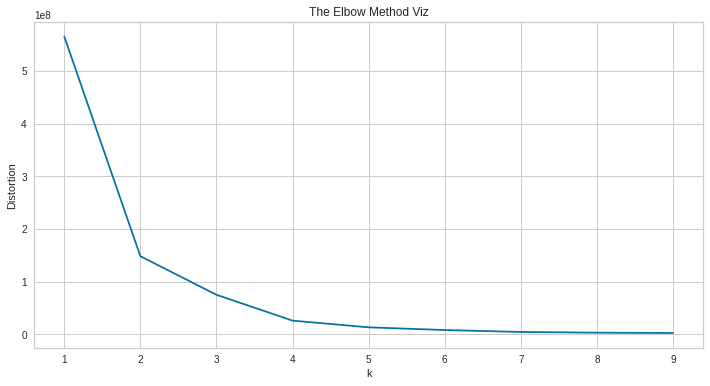

In [17]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

altitudes = np.asarray(measures['altitude'].tolist())
altitudes = altitudes.reshape(-1, 1)

K = range(1, 10)
distortion = []

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(altitudes)
    distortion.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(K, distortion, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method Viz')
plt.show()

**Clustering results**:
We chose the basic distortion metric, which computes the sum of squared distances from each point to its assigned center: sum(x_i.sub(mu_k_i).pow(2)). As the elbow graph indicates, the optimal number of clusters is 4. Empirically speaking, the distortion metric does not significantly decrease after 4 clusters k.

In [138]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(altitudes)

measures['alt_index'] = kmeans.predict(altitudes)
measures.head(3)

,LocationName,SensorUnit_ID,CO2,Temperature,Humidity,zone,altitude,LON,LAT,alt_index
Timestamp,,,,,,,,,,
2017-10-01 00:00:00,AJGR,1122,340.231893,9.800000,95.893425,2,627.8,8.4803,47.33321,1
2017-10-01 00:30:00,AJGR,1122,341.213293,9.766667,95.945241,2,627.8,8.4803,47.33321,1
2017-10-01 01:00:00,AJGR,1122,338.625034,9.636667,95.788203,2,627.8,8.4803,47.33321,1


b) **3/15** Plot the monthly median CO2 measurement for each site with respect to the altitude. Annotate each point of the plot with the name of the location (LocationName), and give the same color to stations that belong to the same altitude  cluster.    

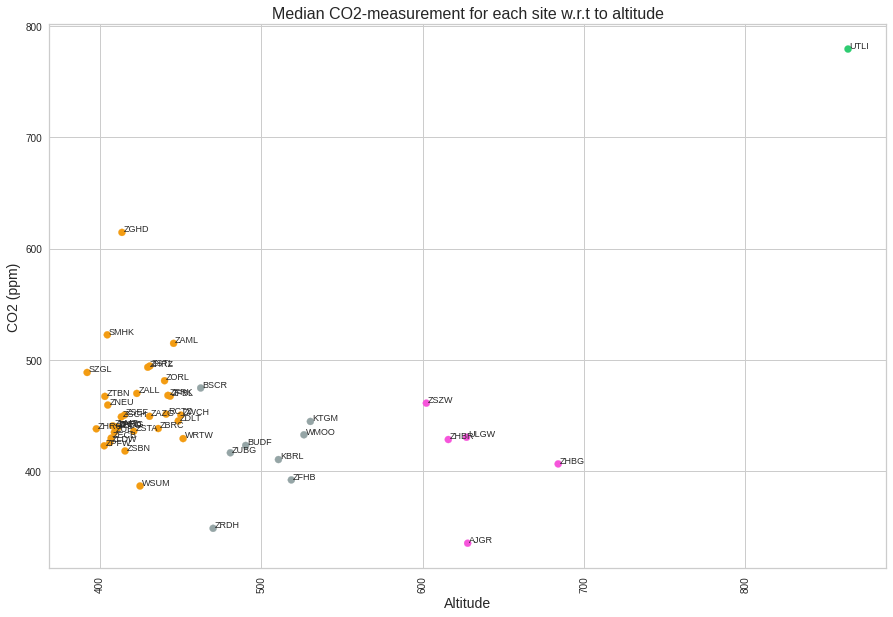

In [140]:
# Retrieve the relevant columns, group them and calculate median
data = measures.iloc[:, lambda df:[0, 2, 6, 9]]
df = data.groupby(['LocationName', 'altitude', 'alt_index']).agg({'CO2':'median'})\
    .sort_values(by='altitude').reset_index()

# Set desired colors for plot
color_map={0:'#95A5A6', 1:'#F655DB', 2:'#2ECC71', 3:'#F39C12'}
colors= df.alt_index.map(color_map)

# Plot results
df.plot.scatter(x='altitude', y='CO2',figsize=(15,10), rot=90, color=colors, s=50)
plt.ylabel('CO2 (ppm)', fontsize=14)
plt.xlabel('Altitude', fontsize=14)
plt.title('Median CO2-measurement for each site w.r.t to altitude', fontsize=16)

for i,label in enumerate(df.LocationName):
    x = df.altitude[i]
    y = df.CO2[i]
    plt.text(x+1, y+1, label, fontsize=9)

c) **7/15** Plot the stations on an interactive Zurich map, and dispay their location name. And, on the same map, plot a time-varying heatmap of the mean daily CO2 concentration for all the stations.

__Note__: You can use the python library [Folium](https://python-visualization.github.io/folium/) for that, but any other visualization tools can be used.

In [132]:
import folium
from folium import plugins

zurich_map = folium.Map(location=[47.37757607, 8.530396999],tiles = "Stamen Terrain", 
                        zoom_start = 12, control_scale=True)

markers = measures.groupby(['LocationName', 'LON'])['LAT'].min().reset_index()
markersList = list(zip(markers['LocationName'].tolist(), markers['LAT'].tolist(), 
                       markers['LON'].tolist()))
#Insert locations into map.
for location in markersList:
    folium.Marker(location[1:3],
              popup=location[0],
              icon=folium.Icon(color='green')
             ).add_to(zurich_map)
    
#Create df with daily mean CO2 values for each coordinate.
heat_data = measures.groupby(['LAT','LON']).resample('D',fill_method='ffill').mean()
heat_data = heat_data['CO2'].reset_index()
heat_data.Timestamp = pd.to_datetime(heat_data.Timestamp, format='%Y-%m-%d %H:%M:%S')
heat_data['day'] = heat_data.Timestamp.apply(lambda x: x.day)

#Create list in list with  day as index and lat, lon and CO2 values as nested index.
df_day_list = []
for day in heat_data.day.sort_values().unique():
    df_day_list.append(heat_data.loc[heat_data.day == day, ['LAT', 'LON', 'CO2']]\
                       .groupby(['LAT', 'LON']).sum().reset_index().values.tolist())

# Plot it on the heat-values on the map.
hm = plugins.HeatMapWithTime(df_day_list, auto_play=True, max_opacity=0.8, 
                             gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, 
                             min_opacity=0.5, use_local_extrema=True)
hm.add_to(zurich_map)
# Display the map
zurich_map

### PART III: Model fitting for data curation (35 points)

a) __3/35__ How to handle missing data matters in real-world data science project. Although here we have all the data, it is still a very good opportunity for you to learn. Let's assume there is one site `KBRL` which somehow lost all the CO2 data of `2017-10-04`. Compare different ways of interpolating for the missing values (in time: linear interpolation and cubic interpolation, in space: using other sensors in the same altitude cluster) and plot the interpolation results. Use the data you have as the ground truth to discuss your findings.

In [141]:
# Remove measurements for site KBRL
kbrl = measures[measures['LocationName'] == 'KBRL']
kbrl.loc['2017-10-04', 'CO2'] = np.nan
alt_index = kbrl.alt_index.unique()

# Interpolate linearily in time
msr_flt_lin = kbrl.CO2.interpolate(method = 'linear')
lin = msr_flt_lin['2017-10-03': '2017-10-05']

# Cubic interpolation in time
msr_flt_cub = kbrl.CO2.interpolate(method = 'cubic')
cub = msr_flt_cub['2017-10-03': '2017-10-05']

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [142]:
# Create new df with sites in same altitude as KBRL and the missing values of KBRL
temp_df = measures.copy()
temp_df[temp_df['LocationName'] == 'KBRL'] = kbrl
temp_df = temp_df[temp_df.alt_index.isin(alt_index)]
temp_df.sort_values(by=['Timestamp', 'altitude'], inplace=True)

# Interpolate linearily in space
msr_flt_space = temp_df.interpolate(method = 'linear')
space = msr_flt_space[msr_flt_space['LocationName'] == 'KBRL']['2017-10-03': '2017-10-05'].CO2

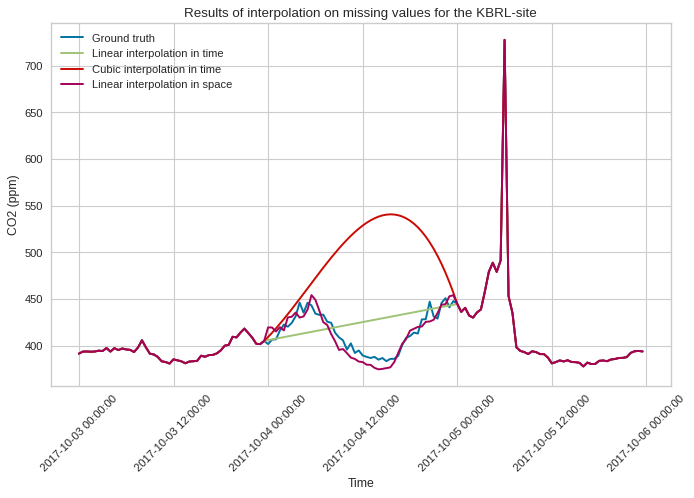

In [154]:
import matplotlib.dates as dates
formatter = dates.DateFormatter('%Y-%m-%d %H:%M:%S') 

# Plot results
figure = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(measures[measures['LocationName'] == 'KBRL']['2017-10-03': '2017-10-05'].CO2)
plt.plot(lin)
plt.plot(cub)
plt.plot(space)
plt.title('Results of interpolation on missing values for the KBRL-site')
plt.xlabel('Time')
plt.ylabel('CO2 (ppm)')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)
plt.xticks(rotation=45) 
plt.grid(True)
plt.legend(('Ground truth', 'Linear interpolation in time', 'Cubic interpolation in time', 
            'Linear interpolation in space'))

**Interpolation result**: *As we can see from the plot, it is more accurate to do the interpolation in space since the sites at similar altitudes have pretty similar values at the same time. When interpolating in time, we are not using any known values from other sites around the same times, which causes the interpolation to be way off the ground truth.* 

b) **2/35** The technician in charge of these sensors reported that one of the CO2 sensors `ZSBN` is exhibiting a drift on Oct. 21. Verify the drift by visualizing the CO2 concentration of the drifting sensor and some other sensors from the network. 

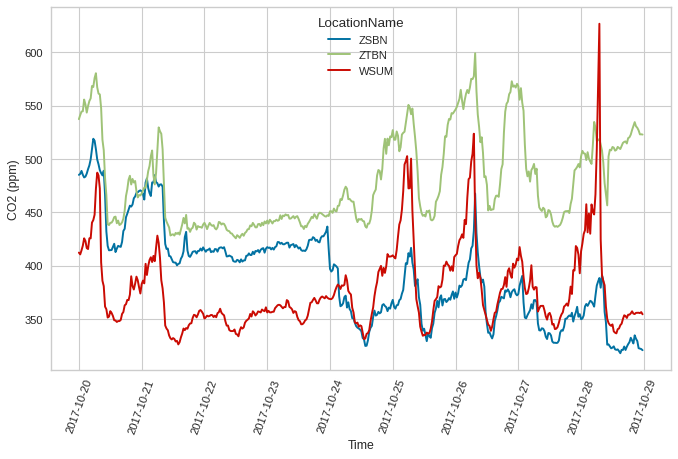

In [155]:
# Define Dataframes for different locations for the time 20.10.2017-28.10.2017
msr_drift = measures[measures['LocationName'] == 'ZSBN']
msr_drift_filt = msr_drift.loc['2017-10-20':'2017-10-28'].reset_index()

msr_non_drift1 =  measures[measures['LocationName'] == 'ZTBN']
msr_non_drift1 = msr_non_drift1.loc['2017-10-20':'2017-10-28'].reset_index()
msr_non_drift2 =  measures[measures['LocationName'] == 'WSUM']
msr_non_drift2 = msr_non_drift2.loc['2017-10-20':'2017-10-28'].reset_index()

# Plot results
figure = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(msr_drift_filt.Timestamp, msr_drift_filt.CO2)
plt.plot(msr_non_drift1.Timestamp, msr_non_drift1.CO2)
plt.plot(msr_non_drift2.Timestamp, msr_non_drift2.CO2)
plt.xlabel('Time')
plt.ylabel('CO2 (ppm)')
plt.xticks(rotation=70)
plt.grid(True)
plt.legend(('ZSBN', 'ZTBN', 'WSUM'), title='LocationName')

c) **6/35** We want to reconstruct the CO2 concentration of the drifting sensor had the drift not happened. Train a forecasting model on the CO2 values of the drifting sensor. Use linear regression with features the past CO2 values over an interval of 3 hours (past 6 observations), mathematically, $C_t \sim h(C_{t-1}, C_{t-2}, C_{t-3}, C_{t-4}, C_{t-5}, C_{t-6})$, where $C_i$ is the CO2 value at time $i$.

Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. What do you observe? 

__Note__: 
1. Cross validation on time series is different from that on other kinds of datasets. scikit-learn provides a nice method for you, `sklearn.model_selection.TimeSeriesSplit`. For more on time series cross validation, there are a lot of interesting articles available online.
2. Think about how to make prediction on data before the drift and after the drift. What's the difference?

**Approach**: We need to create a new table with columns $C_t \sim h(C_{t-1}, C_{t-2}, C_{t-3}, C_{t-4}, C_{t-5}, C_{t-6})$, which represent the CO2 values in shifted time stamps. This is then the input for our regression model , where we are predicting the $C_t$ value. We split this data into train and test sets by the drift date (21.10.2017). 

In [158]:
msr_drift_filt = msr_drift.drop(['LocationName','SensorUnit_ID','Temperature','Humidity',
                                 'zone','altitude','LON','LAT'], axis=1).reset_index()
#Create shifted set of CO2-values
msr_drift_filt['C_t']= msr_drift_filt['CO2'] 
msr_drift_filt['C_t1']= msr_drift_filt['CO2'].shift(1)
msr_drift_filt['C_t2']= msr_drift_filt['CO2'].shift(2)
msr_drift_filt['C_t3']= msr_drift_filt['CO2'].shift(3)
msr_drift_filt['C_t4']= msr_drift_filt['CO2'].shift(4)
msr_drift_filt['C_t5']= msr_drift_filt['CO2'].shift(5)
msr_drift_filt['C_t6']= msr_drift_filt['CO2'].shift(6)

#Split into train and test data
msr_drift_filt_train = msr_drift_filt.fillna(0).set_index('Timestamp')['2017-10-01':'2017-10-21']
msr_drift_filt_test  = msr_drift_filt.fillna(0).set_index('Timestamp')['2017-10-21':'2017-10-29']

In [159]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
train_data_x = []
train_data_y = []

# Append values the shifted CO2-values to training data in a sorted manner
for i in range(1, len(msr_drift_filt_train.index)-6): 
    train_data_y.append(msr_drift_filt_train['C_t'][6+i]) 
    train_data_x.append([msr_drift_filt_train['C_t6'][6+i], msr_drift_filt_train['C_t5'][6+i], 
                         msr_drift_filt_train['C_t4'][6+i], msr_drift_filt_train['C_t3'][6+i], 
                         msr_drift_filt_train['C_t2'][6+i], msr_drift_filt_train['C_t1'][6+i]])
#Fit a linear regression model
reg.fit(train_data_x, train_data_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In the next part, we will do a cross-validation of the training set. For this, we do Time Series spliting with 4 folds. We compute the mean distance error for each prediction and fold and save it to the vector dist.

In [160]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

tscv = TimeSeriesSplit(n_splits = 4)
cross = LinearRegression()

train_data_y = []
train_data_x = []

co2 = msr_drift_filt_train['CO2']

dist = []

for train_index, test_index in tscv.split(co2):
    trainx = co2[train_index]
    testx = co2[test_index]
    train_data_x = []
    train_data_y = []
    for i in range(len(trainx) - 6):
        train_data_y.append(trainx[6 + i])
        train_data_x.append(trainx[i:i+6])
    cross.fit(train_data_x, train_data_y)
    test_data_x = []
    test_data_y = []
    for i in range(len(testx) - 6):
        test_data_y.append(testx[i+6])
        test_data_x.append(testx[i:i+6])
    pred = cross.predict(test_data_x)
    pred = np.array(pred)
    y = np.array(test_data_y)
    d = sum((y - pred))/(len(test_data_y))
    dist.append(d)

dist


[-0.558902615417136, 2.310904899242645, 4.460934679416917, 0.7270126839698804]

We use the previously defined regression model reg to do the prediction. 

In [161]:
#Do recursive prediction based on the CO2 values.
pred = [0 for i in range(len(msr_drift_filt))]
c = [0 for i in range(len(msr_drift_filt))]
for i in range(len(msr_drift_filt_train)): c[i] = (msr_drift_filt_train['CO2'].tolist())[i]
for i in range(6, len(msr_drift_filt)):
    x = np.array(c[i - 6:i]).reshape(1, -1)
    p = reg.predict(x)
    if i >= len(msr_drift_filt_train):
        c[i] = p
    pred[i] = p

In [163]:
#Calculate the mean and std of the distance validation and define upper and lower bounds for the confidence intervall, where you add/substract the standard deviation to each observation
dist = np.array(dist)
mean = np.mean(dist)
std = np.std(dist)
upper = [x + std for x in pred]
lower = [x - std for x in pred]

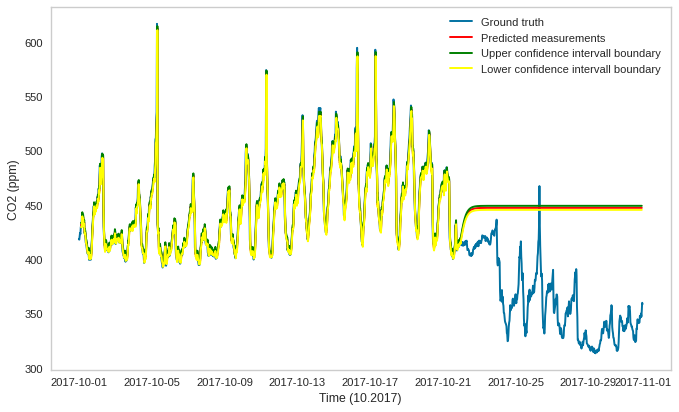

In [164]:
#Plot the ground truth, the predicted values and the confidence intervall
figure = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(msr_drift.index, msr_drift.CO2)
plt.plot(msr_drift.index[6:-2],np.array(pred[6:-2]),color='red')
plt.plot(msr_drift.index[6:-2],np.array(upper[6:-2]),color='green')
plt.plot(msr_drift.index[6:-2],np.array(lower[6:-2]),color='yellow')
plt.xlabel('Time (10.2017)')
plt.ylabel('CO2 (ppm)')
plt.grid()
plt.legend(('Ground truth', 'Predicted measurements', 'Upper confidence intervall boundary', 'Lower confidence intervall boundary'))

**Discussion**: *As we can see from the plot, our model perfectly fits the observations before the drift, which is logical, because we tested with training data. So, when you make predictions before the drift, it will be a perfect hit.  After the drift, we see a saturation of the predictions, as we the test data differs now from the training data. We are making predictions based on previous predictions and after a while, you reach equilibrium due to the lack of fluctuation. The linear regression does not learn the fluctuation pattern.*

d) **3/35** Train a second forecasting model on the CO2 values of the drifting sensor. In this step, use __current__ values of temperature and humidity as features,  as well as their __past__ values over the same interval of three hours, mathematically, $C_t \sim h(T_{t}, \cdots, T_{t-6}, H_{t}, \cdots, H_{t - 6})$, where $T_i$ and $H_i$ are temperature and humidity at time $i$. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. Are you able to remove the drift? If yes, how, if no, why?

In [165]:
msr_drift_filt = msr_drift.drop(['LocationName','SensorUnit_ID','zone','altitude','LON','LAT'],axis=1).reset_index()

#Create shifted set of Temperature-values
msr_drift_filt['T_t']= msr_drift_filt['Temperature']
msr_drift_filt['T_t1']= msr_drift_filt['Temperature'].shift(1)
msr_drift_filt['T_t2']= msr_drift_filt['Temperature'].shift(2)
msr_drift_filt['T_t3']= msr_drift_filt['Temperature'].shift(3)
msr_drift_filt['T_t4']= msr_drift_filt['Temperature'].shift(4)
msr_drift_filt['T_t5']= msr_drift_filt['Temperature'].shift(5)
msr_drift_filt['T_t6']= msr_drift_filt['Temperature'].shift(6)

#Create shifted set of Humidity-values
msr_drift_filt['H_t']= msr_drift_filt['Humidity'] 
msr_drift_filt['H_t1']= msr_drift_filt['Humidity'].shift(1)
msr_drift_filt['H_t2']= msr_drift_filt['Humidity'].shift(2)
msr_drift_filt['H_t3']= msr_drift_filt['Humidity'].shift(3)
msr_drift_filt['H_t4']= msr_drift_filt['Humidity'].shift(4)
msr_drift_filt['H_t5']= msr_drift_filt['Humidity'].shift(5)
msr_drift_filt['H_t6']= msr_drift_filt['Humidity'].shift(6)

#Split into train and test data
msr_drift_filt_train = msr_drift_filt.fillna(0).set_index('Timestamp')['2017-10-01':'2017-10-21']
msr_drift_filt_test  = msr_drift_filt.fillna(0).set_index('Timestamp')['2017-10-21':'2017-10-29']

In [166]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True)
train_data_x = []
train_data_y = []

# Append values the shifted Temperature and Humidity-values to training data in a sorted manner
for i in range(1, len(msr_drift_filt_train.index)-6): 
    train_data_y.append(msr_drift_filt_train['CO2'][6+i]) 
    train_data_x.append([msr_drift_filt_train['T_t6'][6+i], msr_drift_filt_train['T_t5'][6+i], 
                         msr_drift_filt_train['T_t4'][6+i], msr_drift_filt_train['T_t3'][6+i], 
                         msr_drift_filt_train['T_t2'][6+i], msr_drift_filt_train['T_t1'][6+i], 
                         msr_drift_filt_train['T_t'][6+i],msr_drift_filt_train['H_t6'][6+i], 
                         msr_drift_filt_train['H_t5'][6+i], msr_drift_filt_train['H_t4'][6+i], 
                         msr_drift_filt_train['H_t3'][6+i], msr_drift_filt_train['H_t2'][6+i], 
                         msr_drift_filt_train['H_t1'][6+i], msr_drift_filt_train['H_t'][6+i]])
#Fit a linear regression model   
reg.fit(train_data_x, train_data_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In the next part, we will do a cross-validation of the training set. For this, we do Time Series spliting with 4 folds. We compute the mean distance error for each prediction and fold and save it to the vector dist.

In [167]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

tscv = TimeSeriesSplit(n_splits = 4)
cross = LinearRegression()

train_data_y = []
train_data_x = []

co2 = msr_drift_filt_train['CO2']
temp = msr_drift_filt_train['Temperature']
hum = msr_drift_filt_train['Humidity']

dist = []

for train_index, test_index in tscv.split(co2):
    traint = temp[train_index]
    trainh = hum[train_index]
    trainx = co2[train_index]
    testt = temp[test_index]
    testh = hum[test_index]
    testx = co2[test_index]
    train_data_x = []
    train_data_y = []
    for i in range(len(trainx) - 6):
        train_data_y.append(trainx[6 + i])
        train_data_x.append(traint[i:i+6] + trainh[i:i+6])
    cross.fit(train_data_x, train_data_y)
    test_data_x = []
    test_data_y = []
    for i in range(len(testx) - 6):
        test_data_y.append(testx[i+6])
        test_data_x.append(testt[i:i+6]+testh[i:i+6])
    pred = cross.predict(test_data_x)
    pred = np.array(pred)
    y = np.array(test_data_y)
    d = sum((y - pred))/(len(test_data_y))
    dist.append(d)

dist

[5.029073472316037, 20.12655798764137, 41.314509634099544, 21.038408961573573]

In [171]:
#Calculate the mean and std of the distance validation and define upper and lower bounds for the confidence intervall, where you add/substract the standard deviation to each observation
dist = np.array(dist)
mean = np.mean(dist)
std = np.std(dist)
upper = [x + std for x in C]
lower = [x - std for x in C]

In [169]:
#Do recursive prediction based on the CO2 values.
C_t = []
for i in range(6, len(msr_drift_filt.index)):
    C_t.append(reg.predict([[msr_drift_filt['T_t6'][i], msr_drift_filt['T_t5'][i], 
                             msr_drift_filt['T_t4'][i], msr_drift_filt['T_t3'][i], 
                             msr_drift_filt['T_t2'][i], msr_drift_filt['T_t1'][i], 
                             msr_drift_filt['T_t'][i], msr_drift_filt['H_t6'][i], 
                             msr_drift_filt['H_t5'][i], msr_drift_filt['H_t4'][i], 
                             msr_drift_filt['H_t3'][i], msr_drift_filt['H_t2'][i], 
                             msr_drift_filt['H_t1'][i], msr_drift_filt['H_t'][i]]]))
C = list(map(lambda x: x[0], C_t))

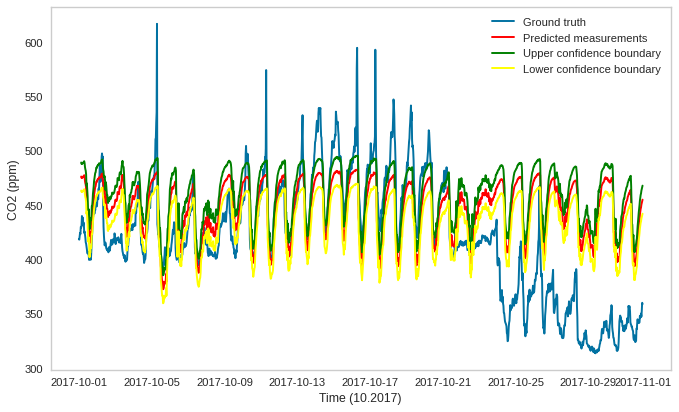

In [173]:
#Plot the ground truth, the predicted values and the confidence intervall

figure = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(msr_drift.index, msr_drift.CO2)
plt.plot(list(msr_drift.index)[6:],C,color='red')
plt.plot(list(msr_drift.index)[6:],upper, color='green')
plt.plot(list(msr_drift.index)[6:],lower, color='yellow')
plt.xlabel('Time (10.2017)')
plt.ylabel('CO2 (ppm)')
plt.grid()
plt.legend(('Ground truth', 'Predicted measurements', 'Upper confidence boundary', 'Lower confidence boundary'))

**Discussion**: We can see that the drift is removed and follows a similar trend that we had before the 21st of October.

e) **6/35** Build another linear regression model by exploting the fact that the CO2 concentrations, as measured by the sensors __experiencing similar conditions__, are expected to be similar. Apply the learned model to the drifting sensor, and plot the results. Discuss your findings.

Learn a model on other sensors: $ C_t^{S} \sim h(T_{t}^{S}, \cdots, T_{t - 6}^{S}, H_{t}^{S}, \cdots, H_{t - 6}^{S})$, where $S$ is the cluster of sensors experiencing similar conditions like ZSBN.

Apply the model on ZSBN to see if the drift has been removed: $\hat{C}_t^{ZSBN} = h(T_{t}^{ZSBN}, \cdots, T_{t - 6}^{ZSBN}, H_{t}^{ZSBN}, \cdots, H_{t - 6}^{ZSBN})$


In [174]:
ind = measures[measures['LocationName'] == 'ZSBN']['alt_index'][0]
ind

3

**Approach**: In this exercise, we chose to select sensor from the same altitude cluster, which should have similar covariate features.

In [175]:
#Select sensor of same altitude cluster.
msr_drift1 = measures[measures['alt_index'] == ind].reset_index().set_index('Timestamp')
msr_drift_filt = msr_drift1.drop(['SensorUnit_ID','zone','altitude','LON','LAT'],axis=1).reset_index()

#Create shifted set of Temperature-values
msr_drift_filt['T_t']= msr_drift_filt['Temperature'] 
msr_drift_filt['T_t1']= msr_drift_filt['Temperature'].shift(1)
msr_drift_filt['T_t2']= msr_drift_filt['Temperature'].shift(2)
msr_drift_filt['T_t3']= msr_drift_filt['Temperature'].shift(3)
msr_drift_filt['T_t4']= msr_drift_filt['Temperature'].shift(4)
msr_drift_filt['T_t5']= msr_drift_filt['Temperature'].shift(5)
msr_drift_filt['T_t6']= msr_drift_filt['Temperature'].shift(6)

#Create shifted set of Humidity-values
msr_drift_filt['H_t']= msr_drift_filt['Humidity'] 
msr_drift_filt['H_t1']= msr_drift_filt['Humidity'].shift(1)
msr_drift_filt['H_t2']= msr_drift_filt['Humidity'].shift(2)
msr_drift_filt['H_t3']= msr_drift_filt['Humidity'].shift(3)
msr_drift_filt['H_t4']= msr_drift_filt['Humidity'].shift(4)
msr_drift_filt['H_t5']= msr_drift_filt['Humidity'].shift(5)
msr_drift_filt['H_t6']= msr_drift_filt['Humidity'].shift(6)

#Training data before drift without the ZSBN location.
msr_drift_filt_train = msr_drift_filt[msr_drift_filt['LocationName'] != 'ZSBN']\
    .fillna(0).set_index('Timestamp')['2017-10-01':'2017-10-21']
msr_drift_filt_test  = msr_drift_filt.fillna(0).set_index('Timestamp')

In [176]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(normalize=True)
train_data_x = []
train_data_y = []

# Append values the shifted Temperature and Humidity-values to training data in a sorted manner
for i in range(1, len(msr_drift_filt_train.index)-6): #corrected to 1
    train_data_y.append(msr_drift_filt_train['CO2'][6+i]) #column [1 2 3 4 5] every iteration
    train_data_x.append([msr_drift_filt_train['T_t6'][6+i], msr_drift_filt_train['T_t5'][6+i], 
                         msr_drift_filt_train['T_t4'][6+i], msr_drift_filt_train['T_t3'][6+i], 
                         msr_drift_filt_train['T_t2'][6+i], msr_drift_filt_train['T_t1'][6+i], 
                         msr_drift_filt_train['T_t'][6+i],  msr_drift_filt_train['H_t6'][6+i], 
                         msr_drift_filt_train['H_t5'][6+i], msr_drift_filt_train['H_t4'][6+i], 
                         msr_drift_filt_train['H_t3'][6+i], msr_drift_filt_train['H_t2'][6+i], 
                         msr_drift_filt_train['H_t1'][6+i], msr_drift_filt_train['H_t'][6+i]])
#Fit the model to training data.    
reg.fit(train_data_x, train_data_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [177]:
#Test with data from ZSBN location
msr_drift_filt_test = msr_drift_filt[msr_drift_filt['LocationName'] == 'ZSBN'].reset_index()
C_t = []
for i in range(6, len(msr_drift_filt_test.index)):
    C_t.append(reg.predict([[msr_drift_filt_test['T_t6'][i], msr_drift_filt_test['T_t5'][i], 
                             msr_drift_filt_test['T_t4'][i], msr_drift_filt_test['T_t3'][i], 
                             msr_drift_filt_test['T_t2'][i], msr_drift_filt_test['T_t1'][i], 
                             msr_drift_filt_test['T_t'][i],msr_drift_filt_test['H_t6'][i], 
                             msr_drift_filt_test['H_t5'][i], msr_drift_filt_test['H_t4'][i], 
                             msr_drift_filt_test['H_t3'][i], msr_drift_filt_test['H_t2'][i], 
                             msr_drift_filt_test['H_t1'][i], msr_drift_filt_test['H_t'][i]]]))
C = list(map(lambda x: x[0], C_t))

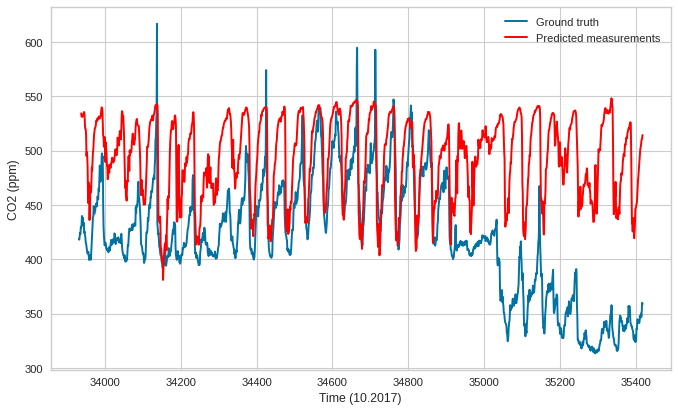

In [179]:
#Plot the ground truth, the predicted values and the confidence intervall
figure = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(msr_drift_filt[msr_drift_filt['LocationName'] == 'ZSBN'].index,msr_drift_filt[msr_drift_filt['LocationName'] == 'ZSBN'].CO2)
plt.plot(msr_drift_filt[msr_drift_filt['LocationName'] == 'ZSBN'].index[6:],C,color='red')
plt.xlabel('Time (10.2017)')
plt.ylabel('CO2 (ppm)')
plt.grid(True)
plt.legend(('Ground truth', 'Predicted measurements'))

**Discussion**: *We see that the consideration of sensors from the same network helps to remove the drift. However, we are not reaching a high accuracy on the predictions.

f) **5/35** Redo the question e) with [statsmodels](https://www.statsmodels.org/stable/index.html), a moudle for statistical models with an extensive list of result statistics. Build the linear regression model with statsmodels and examine the result statistics; keep features whose p-value are strictly less than 0.05 and build a new model. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the new model for the entire month of October. Discuss your findings.

__Note__: This introduciton page of [Linear Regression](https://www.statsmodels.org/stable/regression.html) may be helpful to you.

In [180]:
msr_drift = measures.reset_index().set_index('Timestamp')
msr_drift_filt = msr_drift.drop(['SensorUnit_ID','zone','altitude','LON','LAT'],axis=1)

#Create shifted set of Temperature-values
msr_drift_filt['T_t']= msr_drift_filt['Temperature'] 
msr_drift_filt['T_t1']= msr_drift_filt['Temperature'].shift(1)
msr_drift_filt['T_t2']= msr_drift_filt['Temperature'].shift(2)
msr_drift_filt['T_t3']= msr_drift_filt['Temperature'].shift(3)
msr_drift_filt['T_t4']= msr_drift_filt['Temperature'].shift(4)
msr_drift_filt['T_t5']= msr_drift_filt['Temperature'].shift(5)
msr_drift_filt['T_t6']= msr_drift_filt['Temperature'].shift(6)

#Create shifted set of Humidity-values
msr_drift_filt['H_t']= msr_drift_filt['Humidity']
msr_drift_filt['H_t1']= msr_drift_filt['Humidity'].shift(1)
msr_drift_filt['H_t2']= msr_drift_filt['Humidity'].shift(2)
msr_drift_filt['H_t3']= msr_drift_filt['Humidity'].shift(3)
msr_drift_filt['H_t4']= msr_drift_filt['Humidity'].shift(4)
msr_drift_filt['H_t5']= msr_drift_filt['Humidity'].shift(5)
msr_drift_filt['H_t6']= msr_drift_filt['Humidity'].shift(6)

In [181]:
msr_drift_filt_train = msr_drift_filt.fillna(0)['2017-10-01':'2017-10-21'].reset_index()
msr_drift_filt_test  = msr_drift_filt.fillna(0)['2017-10-21':'2017-10-29'].reset_index()
msr_drift_filt = msr_drift_filt

X = msr_drift_filt_train[['T_t1', 'T_t2', 'T_t3', 'T_t4', 'T_t5', 'T_t6', 'H_t1', 'H_t2', 'H_t3', 'H_t4', 'H_t5', 'H_t6']]
Y = msr_drift_filt_train[['CO2']]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

print(model.summary())
msr_drift_filt

                            OLS Regression Results                            
Dep. Variable:                    CO2   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     392.3
Date:                Tue, 07 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:45:21   Log-Likelihood:            -2.6722e+05
No. Observations:               44587   AIC:                         5.345e+05
Df Residuals:                   44574   BIC:                         5.346e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        364.1034      7.407     49.158      0.0

,LocationName,CO2,Temperature,Humidity,alt_index,T_t,T_t1,T_t2,T_t3,T_t4,T_t5,T_t6,H_t,H_t1,H_t2,H_t3,H_t4,H_t5,H_t6
Timestamp,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00,AJGR,340.231893,9.800000,95.893425,1,9.800000,NaN,NaN,NaN,NaN,NaN,NaN,95.893425,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-01 00:30:00,AJGR,341.213293,9.766667,95.945241,1,9.766667,9.800000,NaN,NaN,NaN,NaN,NaN,95.945241,95.893425,NaN,NaN,NaN,NaN,NaN
2017-10-01 01:00:00,AJGR,338.625034,9.636667,95.788203,1,9.636667,9.766667,9.800000,NaN,NaN,NaN,NaN,95.788203,95.945241,95.893425,NaN,NaN,NaN,NaN
2017-10-01 01:30:00,AJGR,342.874127,9.550000,95.676941,1,9.550000,9.636667,9.766667,9.800000,NaN,NaN,NaN,95.676941,95.788203,95.945241,95.893425,NaN,NaN,NaN
2017-10-01 02:00:00,AJGR,345.171710,9.526667,95.360321,1,9.526667,9.550000,9.636667,9.766667,9.800000,NaN,NaN,95.360321,95.676941,95.788203,95.945241,95.893425,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-31 21:30:00,ZWCH,506.691097,2.496667,85.857274,3,2.496667,2.655000,2.893333,3.230000,3.446667,3.970000,4.566667,85.857274,84.933800,83.756012,82.450750,80.867650,78.956805,77.133698
2017-10-31 22:00:00,ZWCH,507.707888,2.200000,86.636108,3,2.200000,2.496667,2.655000,2.893333,3.230000,3.446667,3.970000,86.636108,85.857274,84.933800,83.756012,82.450750,80.867650,78.956805
2017-10-31 22:30:00,ZWCH,509.046495,1.996667,87.711853,3,1.996667,2.200000,2.496667,2.655000,2.893333,3.230000,3.446667,87.711853,86.636108,85.857274,84.933800,83.756012,82.450750,80.867650


In [182]:
#Fit a ordinary least squares model.
X = msr_drift_filt[msr_drift_filt['LocationName'] != 'ZSBN'].fillna(0)[['T_t1', 'T_t2', 'T_t6', 'H_t1', 'H_t2', 'H_t6']]
Y = msr_drift_filt[msr_drift_filt['LocationName'] != 'ZSBN'].fillna(0)[['CO2']]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
#Do the predictions based on the model.
pred = msr_drift_filt[msr_drift_filt['LocationName'] == 'ZSBN'][['T_t1', 'T_t2', 'T_t6', 'H_t1', 'H_t2',  'H_t6']]
pred = sm.add_constant(pred)
predictions = model.predict(pred).fillna(0)
predictions

Timestamp
2017-10-01 00:00:00    500.238439
2017-10-01 00:30:00    428.711718
2017-10-01 01:00:00    461.713974
2017-10-01 01:30:00    463.813124
2017-10-01 02:00:00    463.183106
                          ...    
2017-10-31 21:30:00    489.160767
2017-10-31 22:00:00    490.708931
2017-10-31 22:30:00    492.448287
2017-10-31 23:00:00    493.200509
2017-10-31 23:30:00    495.038212
Length: 1488, dtype: float64

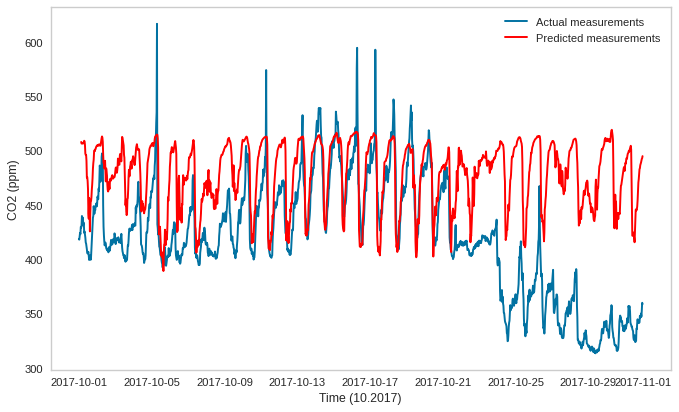

In [183]:
#Plot results
figure = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(msr_drift_filt[msr_drift_filt['LocationName'] == 'ZSBN'].index, msr_drift_filt[msr_drift_filt['LocationName'] == 'ZSBN'].CO2)
plt.plot(msr_drift_filt[msr_drift_filt['LocationName'] == 'ZSBN'].index[6:],predictions[6:],color='red')
plt.xlabel('Time (10.2017)')
plt.ylabel('CO2 (ppm)')
plt.grid()
plt.legend(('Actual measurements', 'Predicted measurements'))

**Discussion**: As we can see, we have very similar results as in question f., which is logical, as the input data is the same, only the method used is different. We have a slightly higher accuracy of the model.

g) **10/35** In this question, we will use __Bayesian Structural Time Serie Modelling__ to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 21.  We will use the information of provided by similar sensors (the ones you identified in the previous question), together with the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/dafiti/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Before you start, watch first the [presentation](https://www.youtube.com/watch?v=GTgZfCltMm8) given by Kay Brodersen (one of the creators of the causal impact implementation in R), and this introductory [ipython notebook](http://nbviewer.jupyter.org/github/dafiti/causalimpact/blob/master/examples/getting_started.ipynb) with examples of how to use the python package.


Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements?

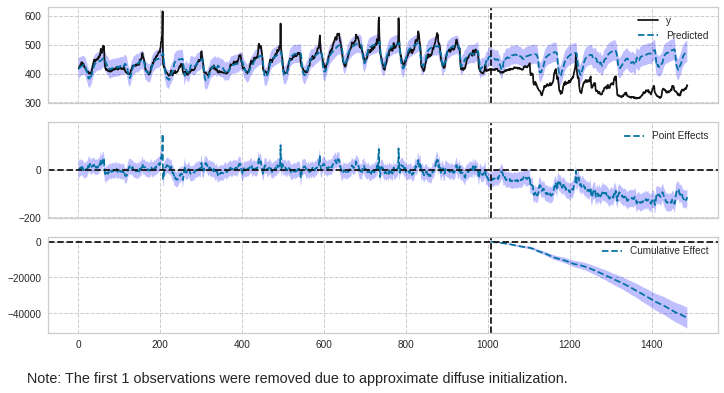

In [46]:
from causalimpact import CausalImpact
msr_drift1 = measures[measures['LocationName'] == 'ZSBN'].reset_index().set_index('Timestamp')[['Temperature', 'Humidity', 'CO2']]
msr_drift2 = measures[measures['LocationName'] != 'ZSBN'].reset_index().set_index('Timestamp')[['Temperature', 'Humidity', 'CO2']]
msr_drift2['C'] = msr_drift2['CO2']
data = pd.DataFrame({'x0': msr_drift1['Temperature'], 'x1': msr_drift1['Humidity'], 'y': msr_drift1['CO2']}, columns=['y', 'x0', 'x1']).reset_index().drop(['Timestamp'], axis=1)
pre_period = [0, 1008]
post_period = [1009, 1487]
ci = CausalImpact(data, pre_period, post_period)
ci.plot(figsize=(12, 6))

In [55]:
msr_drift1 = measures[measures['LocationName'] == 'ZSBN'].reset_index().set_index('Timestamp')[['Temperature', 'Humidity', 'CO2']]
zbrc = measures[measures['LocationName'] == 'ZBRC'].fillna(0)


data = pd.DataFrame({'x0': msr_drift1['Temperature'], 'x1': msr_drift1['Humidity'], 'x2':zbrc['CO2'], 'x3': zbrc['Temperature'], 'x4': zbrc['Humidity'], 'y': msr_drift1['CO2']}, columns=['y', 'x0', 'x1', 'x2', 'x3', 'x4']).reset_index()
dated_data = data.set_index('Timestamp')

pre_period = ['2017-10-01 00:00:00', '2017-10-21 23:30:00']
post_period = ['2017-10-22 00:00:00', '2017-10-31 23:30:00']

figsize = (20, 6)
ci = CausalImpact(dated_data, pre_period, post_period)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


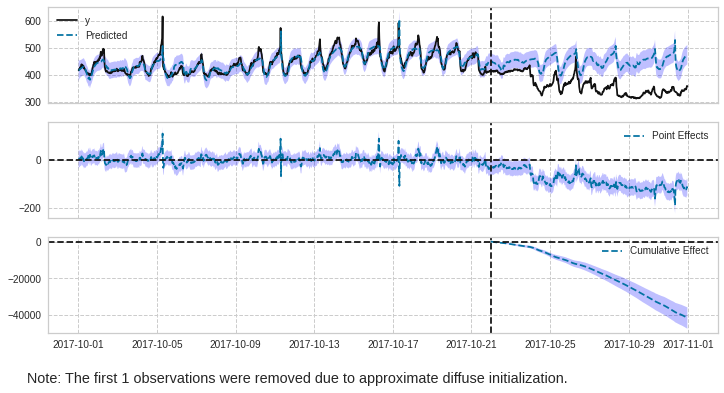

In [56]:
ci.plot(figsize=(12, 6))

**Discussion**: In this approach, we compared two CausalImpact models. One uses only the data from ZSBN location, the second also takes data from a sensor in the same altitude index. As we can see, there is a little improvement in the removal of the drift in the second approach (the more time series covariant you use, the better).

h) **Bonus (5):** Remove the drift with an advanced machine learning model of your choice. Discuss the results. 

**Approach**: We decided to do a pre-processing of the data with a PCA and afterwards, we do the linear regression as we did before. In this way, we get to decrease the noise in the training data and therefore increase the quality of predictions.

In [184]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

train_data_x = []
train_data_y = []

msr_drift = measures

msr_drift_filt = msr_drift.drop(['LocationName','SensorUnit_ID',
                                 'zone','altitude','LON','LAT'], axis=1).reset_index()

msr_drift_filt['C_t']= msr_drift_filt['CO2']
msr_drift_filt_train = msr_drift_filt.fillna(0).set_index('Timestamp')['2017-10-01':'2017-10-21']
msr_drift_filt_test  = msr_drift_filt.fillna(0).set_index('Timestamp')['2017-10-21':'2017-10-29']

trainT = msr_drift_filt_train['Temperature'].tolist()
trainH = msr_drift_filt_train['Humidity'].tolist()
train = msr_drift_filt_train['CO2'].tolist()
for i in range(1, len(train)-6): 
    train_data_y.append(train[6+i]) 
    train_data_x.append(trainT[i:i+6] + trainH[i:i+6] + train[i:i+6])
    
    
x = pca.fit_transform(train_data_x)

In [185]:
reg = LinearRegression()
reg.fit(x, train_data_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [186]:
#pred = [0 for i in range(len(msr_drift_filt))]
msr_drift_filt1 = msr_drift[msr_drift['LocationName'] == 'ZSBN']
testT = msr_drift_filt1['Temperature'].tolist()
testH = msr_drift_filt1['Humidity'].tolist()
test = msr_drift_filt1.fillna(0)['2017-10-01':'2017-10-21']['CO2'].tolist()
pred = [0 for i in range(len(msr_drift_filt1))]
c = [0 for i in range(len(msr_drift_filt1))]
for i in range(len(test)): c[i] = test[i]
for i in range(6, len(msr_drift_filt1)):
    x = np.array(testT[i-6:i] + testH[i-6:i] + c[i-6:i]).reshape(1, -1)
    x = pca.transform(x)
    p = reg.predict(x)
    if i >= len(test):
        c[i] = p
    pred[i] = p


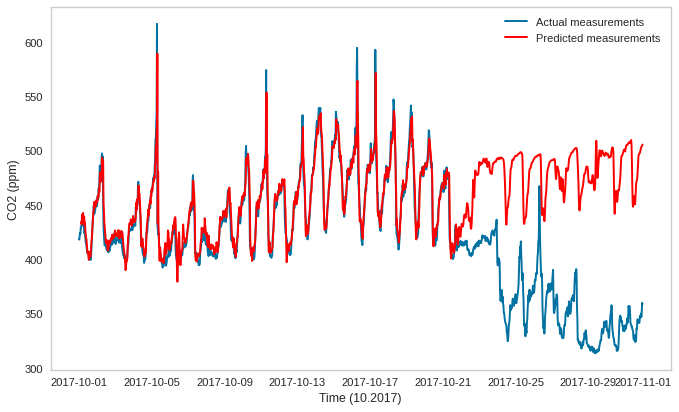

In [187]:
figure = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(msr_drift[msr_drift['LocationName'] == 'ZSBN'].index, msr_drift[msr_drift['LocationName'] == 'ZSBN'].CO2)
plt.plot(msr_drift_filt1.index[6:],pred[6:],color='red')
plt.xlabel('Time (10.2017)')
plt.ylabel('CO2 (ppm)')
plt.grid()
plt.legend(('Actual measurements', 'Predicted measurements'))

**Discussion**: As we can see, this approach yields the best results. We have a perfect hit on the data before the drift and after we follow a reasonable trend.